These imports are responsible for setting chess positions and querying the tablebase for win/loss/draw values. They can be downloaded with `pip install python-chess`.

In [1]:
import chess
import chess.syzygy
import chess.svg

These functions are used to create all of the board positions that the different pieces can occupy.

In [ ]:
def recursiveLoopNoDupes(takeValues, temp, currIndex, out):
    
    tempCopy = temp.copy()
    
    for i in range(0, len(takeValues)):
        
        tempCopy[currIndex] = takeValues[i]
        
        if len(set(tempCopy)) == len(tempCopy):
            out.append(tempCopy.copy())
        
        if currIndex != len(tempCopy) - 1:
            recursiveLoopNoDupes(takeValues, tempCopy, currIndex + 1, out)
            
def recursiveLoopAllowDupes(takeValues, temp, currIndex, out):
    
    tempCopy = temp.copy()
    
    for i in range(0, len(takeValues)):
        
        tempCopy[currIndex] = takeValues[i]
        
        out.append(tempCopy.copy())
        
        if currIndex != len(tempCopy) - 1:
            recursiveLoopAllowDupes(takeValues, tempCopy, currIndex + 1, out)

This runs the function to generate every combination of board positions for the number of pieces you specified. For example, with `pieceCount = 3`, it will generate `[[0, 1, 2], [0, 1, 3], [0, 1, 4], ..., [63, 62, 61]]`.

In [ ]:
takeValues = range(0, 64) # 64 total squares on a chess board
pieceCount = 3 # Change this if you'd like to generate combinations of more than just three pieces (it may take a long time above 4)
squares = [0] * pieceCount
pieceLocations = []
recursiveLoopNoDupes(takeValues, squares, 0, pieceLocations)
pieceLocations = [tuple(item) for item in pieceLocations] # Convert to list of tuples for next line
pieceLocations = set(pieceLocations) # Convert to set to remove duplicates
pieceLocations = [list(item) for item in pieceLocations] # Convert back to list of lists

This will generate every permutation of pieces that you specified. For example, for KPvK, you'd have $3! = 6$ different lists for white king, black king, and white pawn, and six more lists for white king, black king, and black pawn.

In [ ]:
kings = [(6, True), (6, False)] # 1 = pawn, 2 = knight, 3 = bishop, 4 = rook, 5 = queen, 6 = king | True = white, False = black
allPieces = [(1, True), (1, False)] # This is for KPvK, change to the next line if you want to have access to all pieces
#allPieces = [(1, True), (2, True), (3, True), (4, True), (5, True), (1, False), (2, False), (3, False), (4, False), (5, False)]

# The rest of this code gets every permutation of the non-king pieces and then combines them with the kings after
takeValues = allPieces
temp = [()] * (pieceCount - 2)
nonKings = []
recursiveLoopAllowDupes(takeValues, temp, 0, nonKings)

nonKings = [item for item in nonKings if () not in item]

import itertools

newNonKings = []
for nonKing in nonKings:
    
    perms = itertools.permutations(nonKing)
    
    notIn = True
    for perm in perms:
        if list(perm) in newNonKings:
            notIn = False
            break
            
    if notIn:
        newNonKings.append(nonKing)
        
nonKings = newNonKings

for nonKing in nonKings:
    nonKing.append(kings[0])
    nonKing.append(kings[1])
    
if len(nonKings) == 0:
    allPieceCombinations = [kings]
    pieces = [kings]
else:
    allPieceCombinations = nonKings
    pieces = allPieceCombinations
    
allPieceCombinations

This is the final step to generating all of the data. It will loop through every list of pieceLocations and place each permutation of pieces at those locations. In theory, for KPvK, there will be $64 \times 63 \times 62 \times 2 \times 6 = 2,999,808$ different positions. In practice, about a third of these are illegal (kings too close, kings starting in check, pawns on the very end or beginning of board). For each legal iteration, two matrices (layers) will be created, each one corresponding to a specific type of piece. The first matrix corresponds to the location of the pawn (in this case), and the second corresponds to the locations of the kings. White pieces have a `1` at their square, and black pieces have a `-1`, while all other squares get a `0`.

***WARNING: The following code took more than 9 hours to run.*** The code prints roughly every 30 seconds with how far along it is and an estimate of how much longer is left. Each time, it prints, it also attempts to save everything. However, this doesn't actually work. The reason it is still kept is because you might need to pause the code. For some reason, trying to stop the kernel doesn't work, but with the `dump_session` command running, stopping the kernel causes an error and forces the kernel to stop. After it successfully stops ***make sure to run the next line of code***. This is another `dump_session` line, but this time it actually works. Stopping the kernel while saving corrupts the save file, so you won't be able to load it again if need be. ***Make sure to save it again after***. However, as the loop continues, the `dump_session` command will slowly start to take longer each iteration, since the file size is getting bigger. The best thing to do is stop the kernel, make sure to save once more, copy the save and rename it, print out and note the `currentIndex` variable, and restart the kernel to remove all variables. After restarting, replace the `0` in `currentIndex` with whatever value you noted, and start it again. Keep doing this process to keep the loop time fast, and at the end you can load all of them individually and combine them into one variable and perform one last save. Make sure to rename the `outMatrices` and `scores` variables each time you load a save when you're combining them, otherwise you'll overwrite them.

In [ ]:
currentIndex = 0
outMatrices = []
scores = []

In [ ]:
import numpy as np
import itertools
import dill

def removeIllegalPositions():
    
    board.turn = chess.WHITE
    
    global currentIndex
    
    for MAININDEX in range(currentIndex, len(pieceLocations)):
        
        currentIndex = MAININDEX
        
        locations = pieceLocations[MAININDEX]
        
        if currentIndex % 250 == 0:
            print(currentIndex, "/", 249984, "=", currentIndex / 249984, "%")
            print("Roughly", (0.13 * (249984 - currentIndex)) / 60, "minutes left")
            dill.dump_session('SAVEFILE.db')

        currentIndex += 1
        
        for currPieces in allPieceCombinations:
                
            perms = itertools.permutations(currPieces)
            for perm in perms:

                board.clear()
                continueLoop = False
                for (i, location) in enumerate(locations):

                    if perm[i][0] == 1:
                        if (0 <= location and location <= 7) or (56 <= location and location <= 63):
                            continueLoop = True
                            break

                    board.set_piece_at(location, chess.Piece(perm[i][0], perm[i][1]))
                    
                if continueLoop:
                    continue

                caughtException = False
                try:
                    with chess.syzygy.open_tablebase("tablebase/") as tablebase:
                        score = tablebase.probe_wdl(board)
                        if score > 0:
                            score = 1
                        elif score < 0:
                            score = -1
                            
                except:
                    caughtException = True
                    
                if not caughtException:
                    
                    matrix = np.zeros((2, 8, 8))
                    for i in range(0, 2):

                        for (index, piece) in enumerate(perm):

                            if i == 0 and piece[0] != 1:
                                continue
                            if i == 1 and piece[0] != 6:
                                continue
                            else:
                                column = 7 - int(locations[index] / 8)
                                row = locations[index] % 8
                                matrix[i, column, row] = 1 if piece[1] is True else -1
                    
                    outMatrices.append(matrix)
                    scores.append(score)
                    
removeIllegalPositions()

***MAKE SURE TO RUN THE FOLLOWING LINE AFTER STOPPING THE LOOP***.

In [ ]:
import dill
dill.dump_session('SAVEFILE.db')

---

At this point, you should have finished the generation process. If you restarted the kernel, the next line will load all of the generated positions (replace the name of the file if you changed it):

In [2]:
import dill
dill.load_session('FINAL_SAVE.db')

Let's check out the number of legal positions (I renamed them to `ALL_POSITIONS` and `ALL_SCORES` on my last save):

In [3]:
len(ALL_POSITIONS)

1991184

This confirms that about one-third of the generated positions were illegal ($\frac{1991184}{2999808} \approx 66.4\%$).

Let's look at the proportions of the different outcomes for the scores:

In [72]:
print("Wins:", round((ALL_SCORES.count(1) / len(ALL_SCORES)) * 100, 2), "%")
print("Draws:", round((ALL_SCORES.count(0) / len(ALL_SCORES)) * 100, 2), "%")
print("Losses:", round((ALL_SCORES.count(-1) / len(ALL_SCORES)) * 100, 2), "%")

Wins: 37.65 %
Draws: 32.87 %
Losses: 29.47 %


Looks like each outcome is almost exactly one-third of the entire data set. 

Now we can set up the CNN model:

In [21]:
import tensorflow as tf
from sklearn.datasets import load_sample_images
from functools import partial

tf.compat.v1.enable_eager_execution()

tf.random.set_seed(42)
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=32, input_shape=[8, 8, 2]),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128, name="extract"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=32, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=16, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=3, activation="softmax")
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 8, 8, 32)          608       
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 extract (Conv2D)            (None, 8, 8, 128)         147584    
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 64)                524352    
                                                                 
 dropout_9 (Dropout)         (None, 64)               

This creates the training set. You can change the training size if you want to train on a smaller number of samples.

In [7]:
training_size = len(ALL_POSITIONS)
X_train = np.asarray(ALL_POSITIONS)
X_train = X_train[0:training_size - 1]
X_train = np.reshape(X_train, (training_size - 1, 8, 8, 2))
y_train = np.asarray(ALL_SCORES)
y_train = y_train[0:training_size - 1] + 1

Time to train the model.

In [22]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=1)

62225/62225 [==============================] - 947s 15ms/step - loss: 0.1494 - accuracy: 0.9420


This is the function that creates the grad-CAM.

In [23]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Finally, results can be displayed. This gets a random board position and converts it back from matrices into actual piece locations to use with the `python-chess` package. The CNN's guess of the score is displayed along with the correct score, and the position is displayed along with the Grad-CAM heatmap. Lastly, the training sample index is displayed for replication if need be.

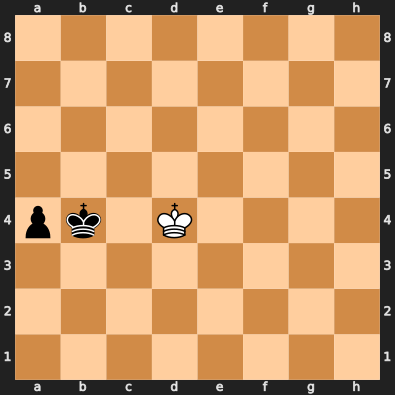

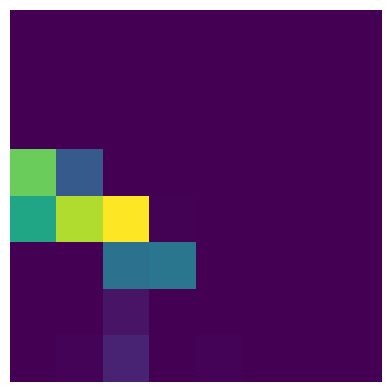

1/1 [==============================] - 0s 22ms/step
GUESS: -1
CORRECT: -1
1697761


In [182]:
from IPython.display import display
import matplotlib.pyplot as plt
from PIL import Image
import keras
import random

# Used in paper:
# Wins: 911089, 400, 1421333
# Draws: 776634, 778901, 1651605
# Losses: 886, 766891, 1697761
num_heatmap = 1697761 # random.randrange(0, training_size - 1)

x = np.expand_dims(X_train[num_heatmap], axis=0)
preprocess_input = keras.applications.xception.preprocess_input
heatmap = make_gradcam_heatmap(x, model, "extract")

board = chess.Board("8/4k3/8/4K3/5P2/8/8/8 w - - 0 1")
board.clear()

pawnIndex = -1
pawnColor = True
for (i, row) in enumerate(ALL_POSITIONS[num_heatmap][0]):
    trueIndex = 64 - (i * 8) - 1
    for (j, element) in enumerate(row):
        if element == 1:
            pawnIndex = trueIndex - (7 - j)
            break
        elif element == -1:
            pawnIndex = trueIndex - (7 - j)
            pawnColor = False
            break
            
whiteKingIndex = -1
blackKingIndex = -1
for (i, row) in enumerate(ALL_POSITIONS[num_heatmap][1]):
    trueIndex = 64 - (i * 8) - 1
    for (j, element) in enumerate(row):
        if element == 1:
            whiteKingIndex = trueIndex - (7 - j)
        elif element == -1:
            blackKingIndex = trueIndex - (7 - j)
            
board.set_piece_at(pawnIndex, chess.Piece(1, pawnColor))
board.set_piece_at(whiteKingIndex, chess.Piece(6, True))
board.set_piece_at(blackKingIndex, chess.Piece(6, False))
boardImage = chess.svg.board(board, size=395)
display(boardImage)

plt.matshow(heatmap)
plt.axis('off')
plt.show()

y_pred = model.predict(np.array([X_train[num_heatmap]]))[0]
new_y_pred = y_pred.copy()

for i in range(0, 3):
     new_y_pred[i] = int(y_pred[i] / np.max(y_pred))
        
final_y_pred = [0] * len(y_pred)
if new_y_pred[0] == 1:
    final_y_pred = -1
elif new_y_pred[1] == 1:
    final_y_pred = 0
else:
    final_y_pred = 1
        
print("GUESS:", final_y_pred)
print("CORRECT:", ALL_SCORES[num_heatmap])
print(num_heatmap)